**Problema a resolver:** el problema a resolver es desarrollar un modelo predictivo capaz de estimar el precio de un boleto de avion, considerando una serie de variables de cada vuelo.

Una vez comprendemos el dominio del problema (factores que influyen en el precio de los boletos de avion) procedemos a determinar las variables que tenemos disponibles y como se pueden relacionar estas con el precio de los boletos

Preparación de datos: unificamos datasets, luego la limpieza de estos y finalmente el EDA.

Seleccionamos caracteristicas o variables mas relevantes para la predicción y transformamos variables que sea necesario transformar utilizando alguna tecnica como get dummies o one hot encoding.

Construimos y evaluamos el o los modelos (dividir datos en test y train) entrenamos  los modelos y ajustamos segun corresponda, optimizamos hiper parametrso para mejorar modelos y finalmente evaluamos utilizando metricas de evaluación.



In [ ]:
!pip install scikit-optimize

!pip install openpyxl

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import cross_val_score

In [ ]:
es

In [ ]:


economy_df = pd.read_excel('/content/economy.xlsx')
business_df = pd.read_excel('/content/business.xlsx')


economy_df['Clase'] = 'Economy'
business_df['Clase'] = 'Business'

# Concatena ambos DataFrames en uno solo
df1 = pd.concat([economy_df, business_df], ignore_index=True)
print(df1.head())


        date   airline ch_code  num_code  dep_time   from time_taken  \
0 2022-02-11  SpiceJet      SG      8709  18:55:00  Delhi    02h 10m   
1 2022-02-11  SpiceJet      SG      8157  06:20:00  Delhi    02h 20m   
2 2022-02-11   AirAsia      I5       764  04:25:00  Delhi    02h 10m   
3 2022-02-11   Vistara      UK       995  10:20:00  Delhi    02h 15m   
4 2022-02-11   Vistara      UK       963  08:50:00  Delhi    02h 20m   

       stop  arr_time      to price    Clase  
0  non-stop  21:05:00  Mumbai  5953  Economy  
1  non-stop  08:40:00  Mumbai  5953  Economy  
2  non-stop  06:35:00  Mumbai  5956  Economy  
3  non-stop  12:35:00  Mumbai  5955  Economy  
4  non-stop  11:10:00  Mumbai  5955  Economy  


In [ ]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300261 non-null  datetime64[ns]
 1   airline     300261 non-null  object        
 2   ch_code     300261 non-null  object        
 3   num_code    300261 non-null  int64         
 4   dep_time    300261 non-null  object        
 5   from        300261 non-null  object        
 6   time_taken  300261 non-null  object        
 7   stop        300261 non-null  object        
 8   arr_time    300261 non-null  object        
 9   to          300261 non-null  object        
 10  price       300261 non-null  object        
 11  Clase       300261 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 27.5+ MB


In [ ]:
# Se crea una columna para identificar la ruta
df1["ruta"] = df1["from"] + " -> " + df1["to"]

# Se eliminan las columnas que no se consideran necesarias
df1 = df1.drop(columns=["num_code", "ch_code"])

In [ ]:
df1['price'] = pd.to_numeric(df1['price'], errors='coerce')
df1.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300261 non-null  datetime64[ns]
 1   airline     300261 non-null  object        
 2   dep_time    300261 non-null  object        
 3   from        300261 non-null  object        
 4   time_taken  300261 non-null  object        
 5   stop        300261 non-null  object        
 6   arr_time    300261 non-null  object        
 7   to          300261 non-null  object        
 8   price       300153 non-null  float64       
 9   Clase       300261 non-null  object        
 10  ruta        300261 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 25.2+ MB


In [ ]:
# Imputación de valores nulos en 'price'
price_median = df1.groupby('Clase')['price'].transform('median')
df1['price'].fillna(price_median, inplace=True)

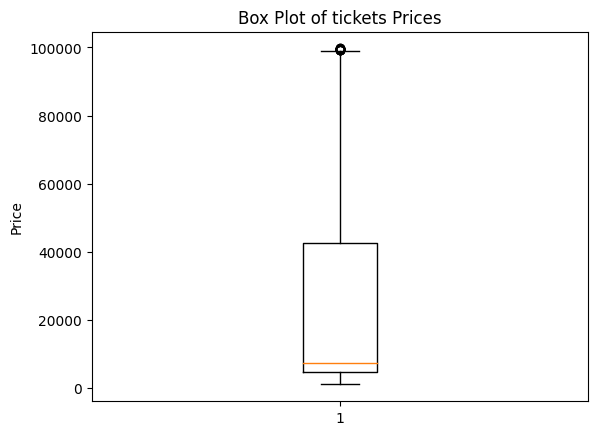

<Axes: >

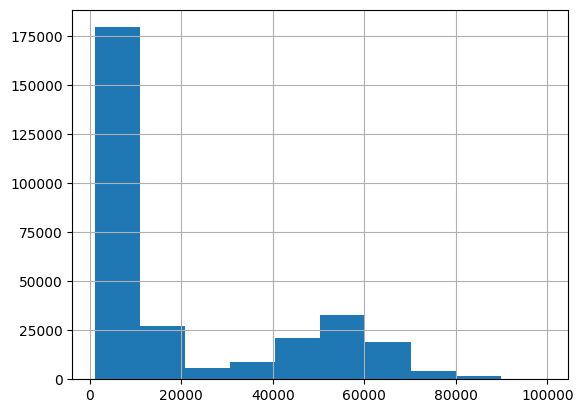

In [ ]:

# Box plot para price
plt.boxplot(df1['price'])
plt.title('Box Plot of tickets Prices')
plt.ylabel('Price')
plt.show()
# Distribución para price
df1['price'].hist()


In [ ]:
# Tratamiento de outliers en 'price'
Q1 = df1['price'].quantile(0.25)
Q3 = df1['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df1 = df1[(df1['price'] >= lower_bound) & (df1['price'] <= upper_bound)]


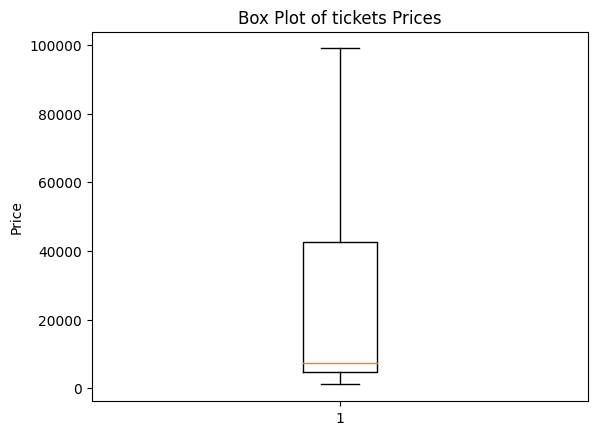

In [ ]:
# Box plot para price v2
plt.boxplot(df1['price'])
plt.title('Box Plot of tickets Prices')
plt.ylabel('Price')
plt.show()

In [ ]:
# Limpieza avanzada de la columna 'stop'
df1['stop'] = df1['stop'].str.replace(r'[\n\t]', ' ', regex=True)  # Remover nuevas líneas y tabulaciones
df1['stop'] = df1['stop'].str.strip()  # Eliminar espacios al inicio y al final
df1['stop'] = df1['stop'].str.lower()  # Convertir a minúsculas para uniformidad

# Conversión de columnas de tiempo
df1['dep_time'] = pd.to_datetime(df1['dep_time'], format='%H:%M:%S').dt.time
df1['arr_time'] = pd.to_datetime(df1['arr_time'], format='%H:%M:%S').dt.time

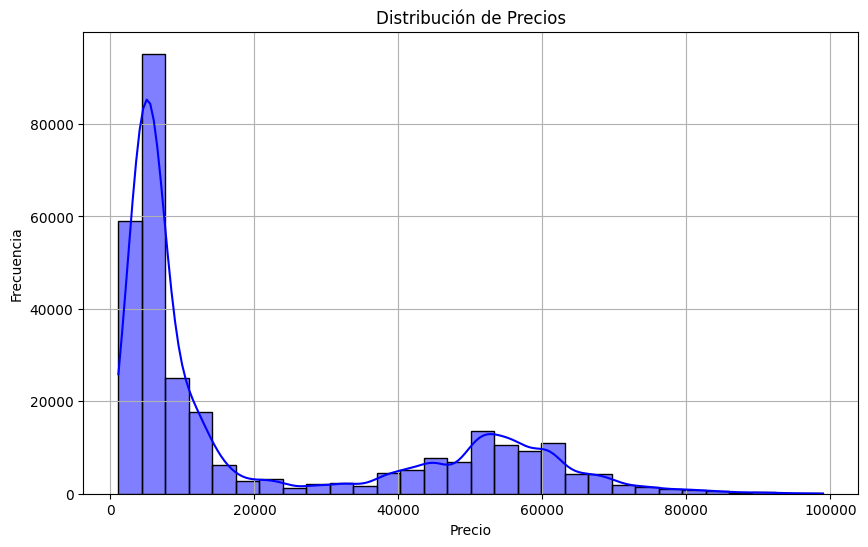

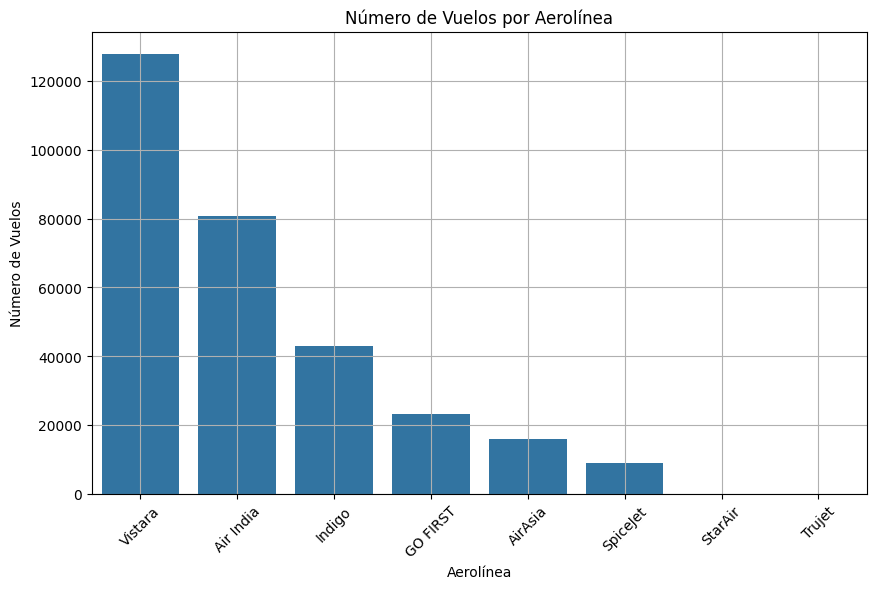

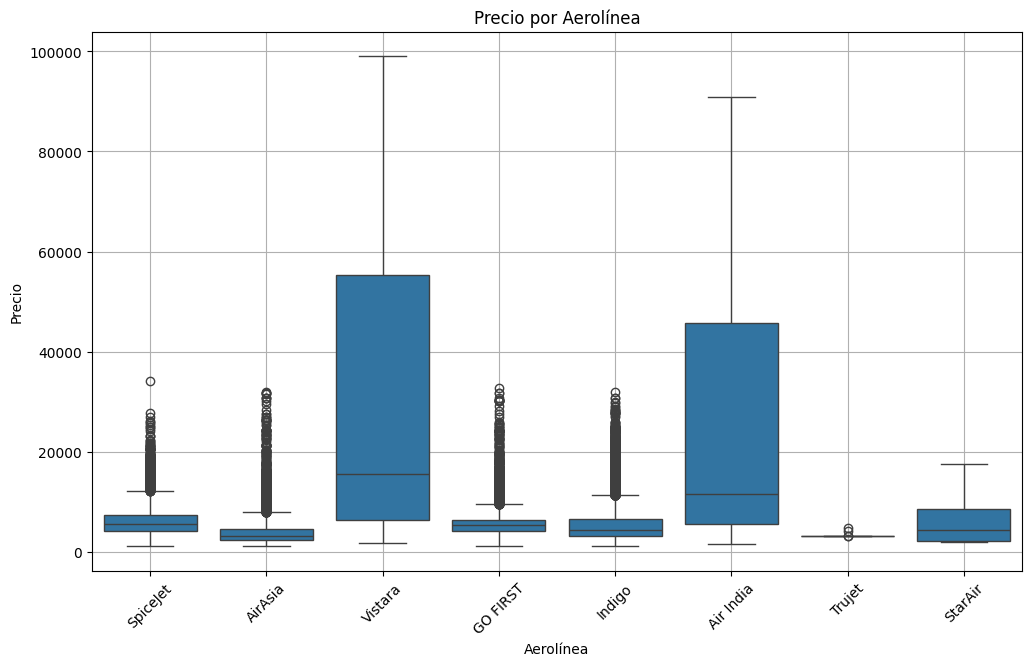

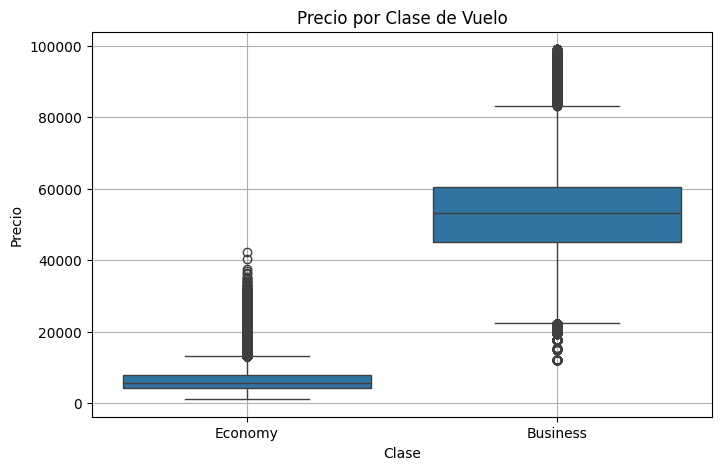

In [ ]:
# Histograma de precios
plt.figure(figsize=(10, 6))
sns.histplot(df1['price'], kde=True, bins=30, color='blue')
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Conteo de vuelos por aerolínea
plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='airline', order = df1['airline'].value_counts().index)
plt.title('Número de Vuelos por Aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Número de Vuelos')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Análisis Bivariado

# Precio por aerolínea
plt.figure(figsize=(12, 7))
sns.boxplot(x='airline', y='price', data=df1)
plt.title('Precio por Aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Precio por clase de vuelo
plt.figure(figsize=(8, 5))
sns.boxplot(x='Clase', y='price', data=df1)
plt.title('Precio por Clase de Vuelo')
plt.xlabel('Clase')
plt.ylabel('Precio')
plt.grid(True)
plt.show()


Análisis Univariado
Distribución de Precios:

La distribución de precios muestra un rango amplio, con una aparente concentración de precios más bajos y una cola larga hacia precios más altos, lo que sugiere que hay menos vuelos con precios muy altos. Esto puede indicar la presencia de vuelos de lujo o tarifas premium que son menos comunes.
Número de Vuelos por Aerolínea:

Algunas aerolíneas operan significativamente más vuelos que otras. Este gráfico muestra la predominancia de ciertas aerolíneas en el dataset, lo que podría influir en análisis posteriores como la capacidad de estas aerolíneas para ofrecer precios competitivos o diferentes niveles de servicio.



Análisis Bivariado
Precio por Aerolínea:

El boxplot de precios por aerolínea revela diferencias en la mediana y la variabilidad de los precios entre las aerolíneas. Algunas aerolíneas tienden a tener precios más altos en promedio, y la variabilidad también difiere, lo que puede reflejar diferentes estrategias de precios o segmentos de mercado objetivo.
Precio por Clase de Vuelo:

Como se esperaría, hay una clara diferencia en los precios entre las clases Business y Economy. La clase Business muestra precios significativamente más altos, lo cual es típico debido al mayor nivel de servicio y comodidad.


In [ ]:
# Extraemos número de paradas
df1["stop"] = df1["stop"].apply(lambda x: re.findall(r"\d+", x)[0] if re.findall(r"\d+", x) else x)
#Cambiamos non_stop por 0
df1["stop"] = df1["stop"].replace("non-stop", "0")
#Convertimos valores a numericos
df1["stop"] = pd.to_numeric(df1["stop"])
df1

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,Clase,ruta
0,2022-02-11,SpiceJet,18:55:00,Delhi,02h 10m,0,21:05:00,Mumbai,5953.0,Economy,Delhi -> Mumbai
1,2022-02-11,SpiceJet,06:20:00,Delhi,02h 20m,0,08:40:00,Mumbai,5953.0,Economy,Delhi -> Mumbai
2,2022-02-11,AirAsia,04:25:00,Delhi,02h 10m,0,06:35:00,Mumbai,5956.0,Economy,Delhi -> Mumbai
3,2022-02-11,Vistara,10:20:00,Delhi,02h 15m,0,12:35:00,Mumbai,5955.0,Economy,Delhi -> Mumbai
4,2022-02-11,Vistara,08:50:00,Delhi,02h 20m,0,11:10:00,Mumbai,5955.0,Economy,Delhi -> Mumbai
...,...,...,...,...,...,...,...,...,...,...,...
300256,2022-03-31,Vistara,09:45:00,Chennai,10h 05m,1,19:50:00,Hyderabad,69265.0,Business,Chennai -> Hyderabad
300257,2022-03-31,Vistara,12:30:00,Chennai,10h 25m,1,22:55:00,Hyderabad,77105.0,Business,Chennai -> Hyderabad
300258,2022-03-31,Vistara,07:05:00,Chennai,13h 50m,1,20:55:00,Hyderabad,79099.0,Business,Chennai -> Hyderabad
300259,2022-03-31,Vistara,07:00:00,Chennai,10h 00m,1,17:00:00,Hyderabad,81585.0,Business,Chennai -> Hyderabad


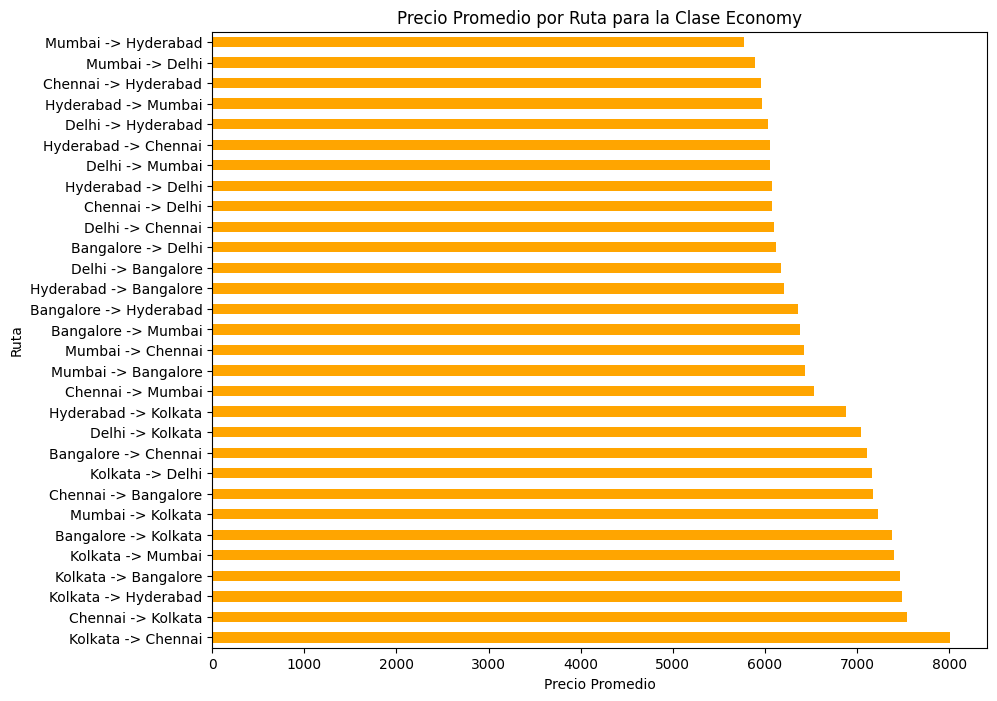

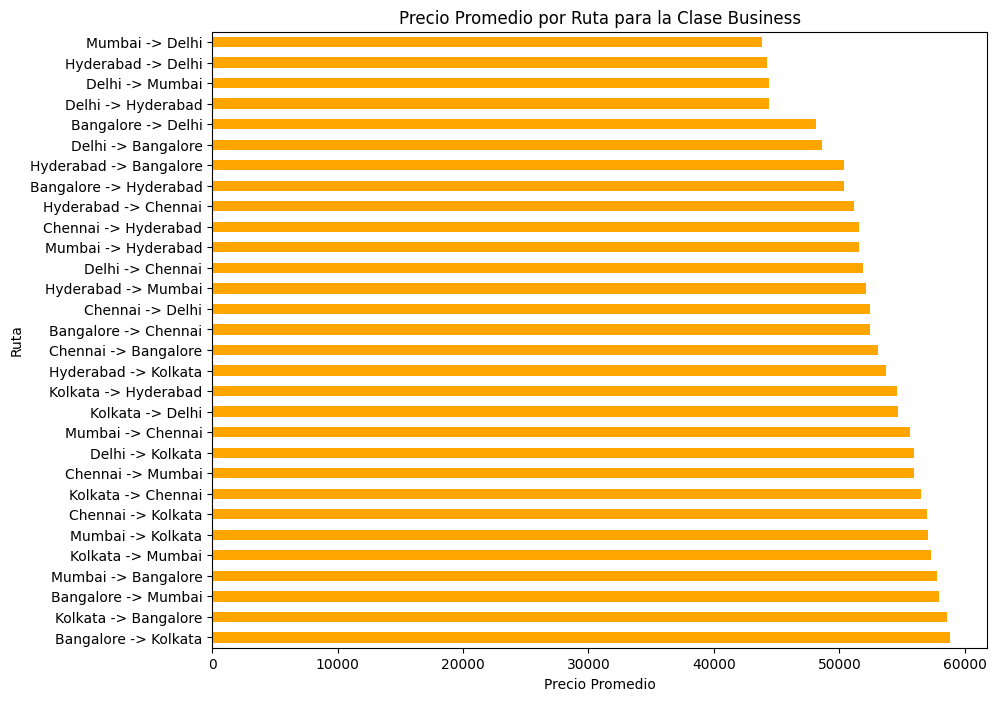

In [ ]:
# Obtener las clases disponibles
clases_disponibles = df1["Clase"].unique()

# Crear un gráfico para cada clase
for clase in clases_disponibles:
    # Filtrar los datos por clase
    datos_clase = df1[df1["Clase"] == clase]

    # Calcular el precio promedio por ruta para la clase actual
    precio_prom_ruta = datos_clase.groupby("ruta")["price"].mean()
    precio_prom_ruta_asc = precio_prom_ruta.sort_values(ascending=False)

    # Crear gráfico para el precio promedio por ruta para la clase actual
    fig, ax = plt.subplots(figsize=(10, 8))
    precio_prom_ruta_asc.plot(kind="barh", ax=ax, color="orange")  # Cambiar el color a naranja

    ax.set_title(f"Precio Promedio por Ruta para la Clase {clase}")
    ax.set_xlabel("Precio Promedio")
    ax.set_ylabel("Ruta")

    # Mostrar el gráfico
    plt.show()



In [ ]:
#Pregunta 5

# Creación de variables para el análisis específico

# 1. Agrupar por Semana del Mes
df1['week_of_month'] = df1['date'].apply(lambda x: (x.day - 1) // 7 + 1)




In [ ]:
# Crear un data frame "df_total" que se quede con las columnas de df1,  'week_of_month' 'quarter' 'month_of_year', 'stop', 'Clase', 'ruta', 'price', 'date'

df_total = df1[['week_of_month', 'stop', 'Clase', 'ruta', 'price', 'date', 'time_taken']]
df_total



,week_of_month,stop,Clase,ruta,price,date,time_taken
0,2,0,Economy,Delhi -> Mumbai,5953.0,2022-02-11,02h 10m
1,2,0,Economy,Delhi -> Mumbai,5953.0,2022-02-11,02h 20m
2,2,0,Economy,Delhi -> Mumbai,5956.0,2022-02-11,02h 10m
3,2,0,Economy,Delhi -> Mumbai,5955.0,2022-02-11,02h 15m
4,2,0,Economy,Delhi -> Mumbai,5955.0,2022-02-11,02h 20m
...,...,...,...,...,...,...,...
300256,5,1,Business,Chennai -> Hyderabad,69265.0,2022-03-31,10h 05m
300257,5,1,Business,Chennai -> Hyderabad,77105.0,2022-03-31,10h 25m
300258,5,1,Business,Chennai -> Hyderabad,79099.0,2022-03-31,13h 50m
300259,5,1,Business,Chennai -> Hyderabad,81585.0,2022-03-31,10h 00m


In [ ]:

# Agrupar por 'week_of_month', 'Clase' y calcular el precio promedio y contar las ocurrencias
grouped_data = df_total.groupby(['week_of_month', 'Clase']).agg({'price': ['mean', 'count']})

# Renombrar las columnas para mayor claridad
grouped_data.columns = ['Precio Promedio', 'Cantidad']

# Restablecer el índice para tener 'week_of_month' y 'Clase' como columnas
grouped_data = grouped_data.reset_index()

# Ordenar los datos primero por 'Clase' (Business primero) y luego por 'week_of_month'
grouped_data = grouped_data.sort_values(['Clase', 'week_of_month'])

# Mostrar los resultados
print(grouped_data)


   week_of_month     Clase  Precio Promedio  Cantidad
0              1  Business     52051.228766     13940
2              2  Business     53609.914452     18773
4              3  Business     52677.505201     27591
6              4  Business     51907.563090     27635
8              5  Business     51469.737575      5533
1              1   Economy      5345.989104     31662
3              2   Economy      7029.195581     41998
5              3   Economy      7616.876599     58241
7              4   Economy      6287.758337     62099
9              5   Economy      4712.424299     12774


Se puede apreciar que la semana del mes en la que fue el vuelo influye en el precio promedio, sin embargo no ocurre de manera lineal.

In [ ]:
import re

# Función para convertir la cadena de tiempo en minutos
def convert_to_minutes(time_str):
    # Buscar los números en la cadena de tiempo, asumiendo el formato "Xh Ym"
    numbers = re.findall(r'\d+', time_str)
    if len(numbers) == 2:
        # Convertir horas y minutos a minutos
        return int(numbers[0]) * 60 + int(numbers[1])
    elif 'h' in time_str:
        # Solo hay horas en la cadena de tiempo
        return int(numbers[0]) * 60
    elif 'm' in time_str:
        # Solo hay minutos en la cadena de tiempo
        return int(numbers[0])
    else:
        # En caso de que el formato sea inesperado
        return None

# Aplicar la función a la columna 'time_taken'
df_total['time_taken_minutes'] = df_total['time_taken'].apply(convert_to_minutes)

# Verificar los resultados
df_total[['time_taken', 'time_taken_minutes']].head()


<ipython-input-18-a840c24b785f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['time_taken_minutes'] = df_total['time_taken'].apply(convert_to_minutes)


,time_taken,time_taken_minutes
0,02h 10m,130
1,02h 20m,140
2,02h 10m,130
3,02h 15m,135
4,02h 20m,140


Al parecer la semana del mes afecta bastante en los precios de Economy, no tanto en el caso de Business por lo que para los modelos solo se considerara en el caso de Enconomy


In [ ]:


df_total = df_total.rename(columns={"Clase": "class"})


In [ ]:
# prompt: quita las columnas "time_taken", "date" de df_total

df_total = df_total.drop(['time_taken', 'date'], axis=1)
df = df_total


In [ ]:
df = df_total


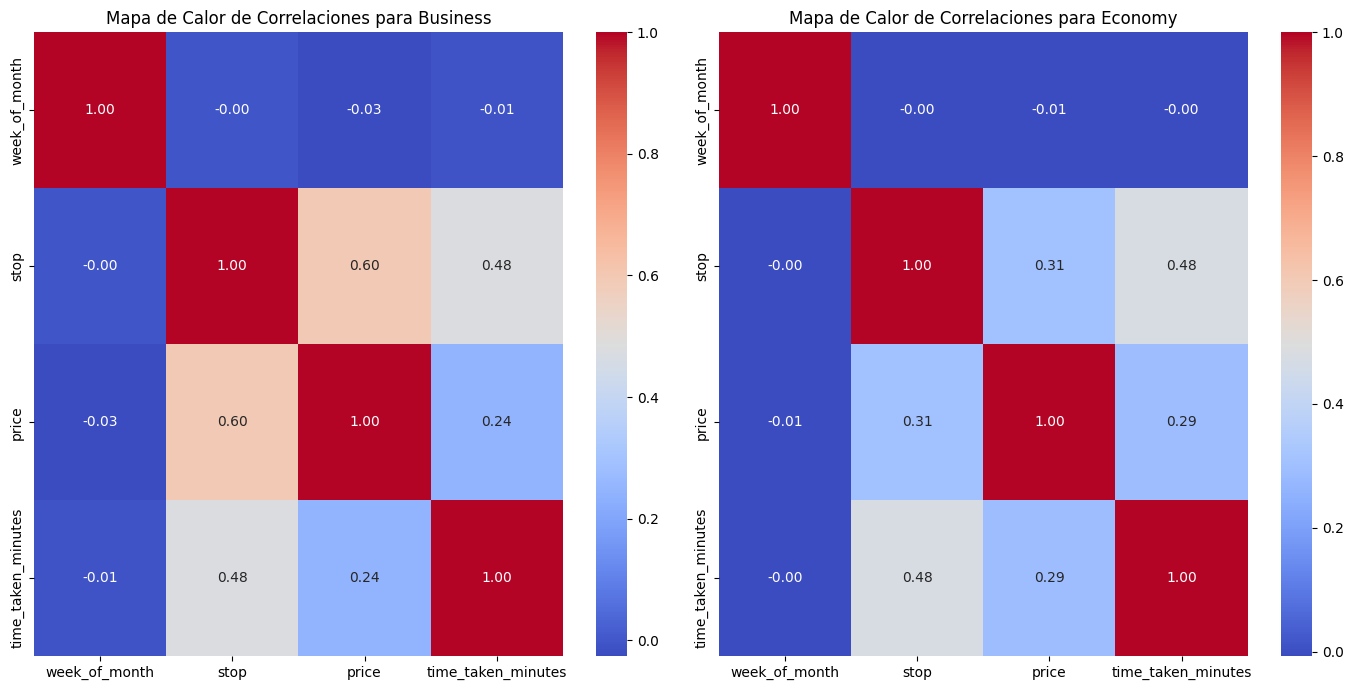

In [ ]:
#Pregunta 4


# Filtrar el DataFrame por la clase 'Business' y 'Economy' y calcular la matriz de correlaciones para cada uno
df_business = df[df['class'] == 'Business'].select_dtypes(include=[float, int])
df_economy = df[df['class'] == 'Economy'].select_dtypes(include=[float, int])

correlation_matrix_business = df_business.corr()
correlation_matrix_economy = df_economy.corr()

# Ahora vamos a crear los mapas de calor de las correlaciones para cada clase
plt.figure(figsize=(14, 7))

# Mapa de calor para la clase 'Business'
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_business, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlaciones para Business')

# Mapa de calor para la clase 'Economy'
plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_economy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlaciones para Economy')

plt.tight_layout()  # Ajusta automáticamente los parámetros para que los subplots no se superpongan
plt.show()


Correlación entre "time_taken_minutes" y "price": La correlación entre estas dos variables es de aproximadamente 0.24 y 0.29. Esto sugiere una correlación positiva débil entre el tiempo de vuelo y el precio del boleto. En otras palabras, a medida que aumenta el tiempo de vuelo, es posible que el precio del boleto también tienda a aumentar, aunque la relación es bastante débil.

Correlación entre "stop" y "price": La correlación entre estas dos variables es de aproximadamente 0.6 para bussines y 0.31 para Economy. Esto sugiere una correlación positivaentre el número de paradas en el vuelo y el precio del boleto. Es importante tener en cuenta que esta correlación es mas fuerte que la anterior.

Correlación entre "time_taken_minutes" y "stop": La correlación entre estas dos variables es de aproximadamente 0.48 en ambos casos. Esto sugiere una correlación positiva moderada entre el tiempo de vuelo y el número de paradas en el vuelo. Es decir, es más probable que vuelos con una duración mayor tengan más paradas.


week_of_monthno presenta correlaciones significativas con ninguna variable

###Pregunta 5 se fue completando a medida que se avanzaba con las preguntas anteriores, sin embargo

In [ ]:
# One hot Encoder
# Paso 1: Codificación de Variables Categóricas usando One-Hot Encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df_total[['class', 'ruta']])

# Crear un DataFrame con las nuevas características codificadas
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['class', 'ruta']))

# Concatenar con el DataFrame original (sin incluir las columnas categóricas originales)
final_df = pd.concat([df_total.drop(['class', 'ruta'], axis=1), encoded_df], axis=1)




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Normalización
# Seleccionar las columnas numéricas para la normalización
numeric_columns = ['week_of_month', 'stop', 'price', 'time_taken_minutes']

# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Aplicar MinMax Scaling a las columnas seleccionadas
final_df[numeric_columns] = scaler.fit_transform(final_df[numeric_columns])

# Mostrar las primeras filas para verificar la normalización
final_df[numeric_columns].head(), final_df.head()


(   week_of_month  stop     price  time_taken_minutes
 0           0.25   0.0  0.049537            0.027211
 1           0.25   0.0  0.049537            0.030612
 2           0.25   0.0  0.049567            0.027211
 3           0.25   0.0  0.049557            0.028912
 4           0.25   0.0  0.049557            0.030612,
    week_of_month  stop     price  time_taken_minutes  class_Business  \
 0           0.25   0.0  0.049537            0.027211             0.0   
 1           0.25   0.0  0.049537            0.030612             0.0   
 2           0.25   0.0  0.049567            0.027211             0.0   
 3           0.25   0.0  0.049557            0.028912             0.0   
 4           0.25   0.0  0.049557            0.030612             0.0   
 
    class_Economy  ruta_Bangalore -> Chennai  ruta_Bangalore -> Delhi  \
 0            1.0                        0.0                      0.0   
 1            1.0                        0.0                      0.0   
 2            1.

In [ ]:
# Pregunta 6:


def preprocess_and_convert_data(filepath, filepath2):
    # Cargar los datos
    economy_df = pd.read_excel(filepath)
    business_df = pd.read_excel(filepath2)

    # Asignar clase
    economy_df['Clase'] = 'Economy'
    business_df['Clase'] = 'Business'

    # Combinar los dos DataFrames
    df = pd.concat([economy_df, business_df], ignore_index=True)

    # Crear columna de ruta
    df["ruta"] = df["from"] + " -> " + df["to"]

    # Eliminar columnas innecesarias
    df = df.drop(columns=["num_code", "ch_code"])

    # Convertir la columna de precio a numérico y manejar valores nulos
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    price_median = df.groupby('Clase')['price'].transform('median')
    df['price'].fillna(price_median, inplace=True)

    # Manejar outliers en la columna 'price'
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

    # Limpieza de la columna 'stop'
    df['stop'] = df['stop'].str.replace(r'[\n\t]', ' ', regex=True)
    df['stop'] = df['stop'].str.strip().str.lower()
    df["stop"] = df["stop"].apply(lambda x: re.findall(r"\d+", x)[0] if re.findall(r"\d+", x) else x)
    df["stop"] = df["stop"].replace("non-stop", "0")
    df["stop"] = pd.to_numeric(df["stop"])

    # Convertir tiempos a datetime
    df['dep_time'] = pd.to_datetime(df['dep_time'], format='%H:%M:%S').dt.time
    df['arr_time'] = pd.to_datetime(df['arr_time'], format='%H:%M:%S').dt.time

    # Conversión de 'time_taken' a minutos
    def convert_to_minutes(time_str):
        numbers = re.findall(r'\d+', time_str)
        if len(numbers) == 2:
            return int(numbers[0]) * 60 + int(numbers[1])
        elif 'h' in time_str:
            return int(numbers[0]) * 60
        elif 'm' in time_str:
            return int(numbers[0])
        else:
            return None

    df['time_taken_minutes'] = df['time_taken'].apply(convert_to_minutes)

    # Extraer semana del mes
    df['week_of_month'] = df['date'].apply(lambda x: (x.day - 1) // 7 + 1)

    # One-Hot Encoding
    encoder = OneHotEncoder(sparse=False)
    encoded_features = encoder.fit_transform(df[['Clase', 'ruta']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Clase', 'ruta']))
    df_total = pd.concat([df.drop(['Clase', 'ruta'], axis=1), encoded_df], axis=1)

    # Normalización
    numeric_columns = ['week_of_month', 'stop', 'price', 'time_taken_minutes']
    scaler = MinMaxScaler()
    df_total[numeric_columns] = scaler.fit_transform(df_total[numeric_columns])

    # Retornar el DataFrame procesado
    return df_total


In [ ]:
# Llamar a la función con la ruta del archivo actualizado
processed_data = preprocess_and_convert_data('/content/economy.xlsx','/content/business.xlsx')


print(processed_data.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


        date   airline  dep_time   from time_taken  stop  arr_time      to  \
0 2022-02-11  SpiceJet  18:55:00  Delhi    02h 10m   0.0  21:05:00  Mumbai   
1 2022-02-11  SpiceJet  06:20:00  Delhi    02h 20m   0.0  08:40:00  Mumbai   
2 2022-02-11   AirAsia  04:25:00  Delhi    02h 10m   0.0  06:35:00  Mumbai   
3 2022-02-11   Vistara  10:20:00  Delhi    02h 15m   0.0  12:35:00  Mumbai   
4 2022-02-11   Vistara  08:50:00  Delhi    02h 20m   0.0  11:10:00  Mumbai   

      price  time_taken_minutes  ...  ruta_Kolkata -> Bangalore  \
0  0.049537            0.027211  ...                        0.0   
1  0.049537            0.030612  ...                        0.0   
2  0.049567            0.027211  ...                        0.0   
3  0.049557            0.028912  ...                        0.0   
4  0.049557            0.030612  ...                        0.0   

   ruta_Kolkata -> Chennai  ruta_Kolkata -> Delhi  ruta_Kolkata -> Hyderabad  \
0                      0.0                    0.

In [ ]:

processed_data = processed_data.drop(['date', 'airline', 'dep_time', 'from', 'time_taken', 'arr_time', 'to'], axis=1)


In [ ]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300261 entries, 0 to 290552
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stop                         300246 non-null  float64
 1   price                        300246 non-null  float64
 2   time_taken_minutes           300246 non-null  float64
 3   week_of_month                300246 non-null  float64
 4   Clase_Business               300246 non-null  float64
 5   Clase_Economy                300246 non-null  float64
 6   ruta_Bangalore -> Chennai    300246 non-null  float64
 7   ruta_Bangalore -> Delhi      300246 non-null  float64
 8   ruta_Bangalore -> Hyderabad  300246 non-null  float64
 9   ruta_Bangalore -> Kolkata    300246 non-null  float64
 10  ruta_Bangalore -> Mumbai     300246 non-null  float64
 11  ruta_Chennai -> Bangalore    300246 non-null  float64
 12  ruta_Chennai -> Delhi        300246 non-null  float64
 13  ruta

In [ ]:


processed_data.dropna()


,stop,price,time_taken_minutes,week_of_month,Clase_Business,Clase_Economy,ruta_Bangalore -> Chennai,ruta_Bangalore -> Delhi,ruta_Bangalore -> Hyderabad,ruta_Bangalore -> Kolkata,...,ruta_Kolkata -> Bangalore,ruta_Kolkata -> Chennai,ruta_Kolkata -> Delhi,ruta_Kolkata -> Hyderabad,ruta_Kolkata -> Mumbai,ruta_Mumbai -> Bangalore,ruta_Mumbai -> Chennai,ruta_Mumbai -> Delhi,ruta_Mumbai -> Hyderabad,ruta_Mumbai -> Kolkata
0,0.0,0.049537,0.027211,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.049537,0.030612,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.049567,0.027211,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.049557,0.028912,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.049557,0.030612,0.25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300241,0.5,0.514494,0.374150,1.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300242,0.5,0.514494,0.389456,1.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300243,0.5,0.514494,0.447279,1.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300244,0.5,0.514494,0.464286,1.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Pregunta 7

# Definir las variables predictoras y la variable objetivo
X = processed_data.drop('price', axis=1)
y = processed_data['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Informar sobre la división realizada
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240208, 35), (60053, 35), (240208,), (60053,))

In [ ]:
# Check for missing values in X_train
missing_values = X_train.isnull().sum().sum()

# Print the number of missing values
print(f"Number of missing values in X_train: {missing_values}")

Number of missing values in X_train: 289


In [ ]:
# Imputar valores faltantes en X
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)

# Imputar valores faltantes en y
# Nota: asegúrate de que y es un DataFrame para que la imputación funcione correctamente
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(y.to_frame())

# Asegúrate de que y_imputed es una serie y no un array bidimensional para el entrenamiento del modelo
y_imputed = y_imputed.ravel()

# Ahora puedes dividir tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)



In [ ]:
# Inicializar los modelos
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

# Entrenar los modelos
linear_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Hacer predicciones con los modelos
y_pred_linear = linear_model.predict(X_test)
y_pred_tree = decision_tree_model.predict(X_test)
y_pred_forest = random_forest_model.predict(X_test)

# Calcular métricas de evaluación
metrics_linear = {
    "MSE": mean_squared_error(y_test, y_pred_linear),
    "MAE": mean_absolute_error(y_test, y_pred_linear),
    "R2": r2_score(y_test, y_pred_linear)
}

metrics_tree = {
    "MSE": mean_squared_error(y_test, y_pred_tree),
    "MAE": mean_absolute_error(y_test, y_pred_tree),
    "R2": r2_score(y_test, y_pred_tree)
}

metrics_forest = {
    "MSE": mean_squared_error(y_test, y_pred_forest),
    "MAE": mean_absolute_error(y_test, y_pred_forest),
    "R2": r2_score(y_test, y_pred_forest)
}

metrics_linear, metrics_tree, metrics_forest

({'MSE': 0.005379372092786143,
  'MAE': 0.05014434270961334,
  'R2': 0.8991731593383792},
 {'MSE': 0.0018172140979705854,
  'MAE': 0.02533765942241587,
  'R2': 0.9659395273009951},
 {'MSE': 0.0017733056906598472,
  'MAE': 0.025428683885526958,
  'R2': 0.9667625129415612})

Estos rendimientos nos entregan la siguiente información:

**Regresión Lineal:**Con un R² de 0.899, el modelo de regresión lineal explica aproximadamente el 89.9% de la variabilidad de los datos de precios. Esto es bastante bueno para un modelo lineal, pero el MSE y el MAE son relativamente altos comparados con los otros modelos. La regresión lineal es una buena línea base y es útil debido a su simplicidad y fácil interpretación. Sin embargo, la presencia de relaciones no lineales entre las características y el precio podría estar limitando su rendimiento.



**Árbol de Decisión para Regresión:**Este modelo ha mostrado un rendimiento superior con un R² de 0.965, lo que significa que casi el 95.6% de la variabilidad en los precios se explica con el modelo. El MSE y MAE bajos indican que las predicciones son, en promedio, bastante cercanas a los valores reales. La mejora significativa con respecto a la regresión lineal sugiere que hay relaciones no lineales y complejas en los datos que el árbol de decisión puede capturar eficientemente.


**Random Forest Regressor:**El rendimiento de este modelo es comparable al del árbol de decisión con un R² de 0.966. Este es un resultado esperado, dado que los bosques aleatorios tienden a mejorar o al menos igualar el rendimiento de un solo árbol de decisión. Los bosques aleatorios son menos propensos al sobreajuste y generalmente tienen un mejor rendimiento en conjuntos de datos no vistos, gracias a que promedian las predicciones de múltiples árboles.

Al tener rendimientos bastante superiores en el arbol y el bosque que en la regresión lineal, optaremos por utilizar estos 2 modelos ya que capturan relaciones no lineales mas complejas que la regresión lineal simple.


In [ ]:
# Pregunta 8

# Espacio de parámetros para Árbol de Decisión
param_space_tree = {
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10)
}

# Espacio de parámetros para Random Forest
param_space_forest = {
    'n_estimators': Integer(30, 100),
    'max_depth': Integer(3, 15),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 8),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Configuración de la búsqueda bayesiana para Árbol de Decisión
opt_tree = BayesSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_space_tree,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Configuración de la búsqueda bayesiana para Random Forest
opt_forest = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    param_space_forest,
    n_iter=20,
    cv=4,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Ejecutar la optimización
opt_tree.fit(X_train, y_train)
opt_forest.fit(X_train, y_train)

# Resultados
print("Mejores parámetros para Árbol de Decisión:", opt_tree.best_params_)
print("Mejor score para Árbol de Decisión:", opt_tree.best_score_)
print("Mejores parámetros para Random Forest:", opt_forest.best_params_)
print("Mejor score para Random Forest:", opt_forest.best_score_)

Mejores parámetros para Árbol de Decisión: OrderedDict([('max_depth', 20), ('min_samples_leaf', 1), ('min_samples_split', 20)])
Mejor score para Árbol de Decisión: -0.002817015002069942
Mejores parámetros para Random Forest: OrderedDict([('max_depth', 15), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
Mejor score para Random Forest: -0.0030592471664831803


In [ ]:

# Reentrenar con los mejores parámetros
optimal_tree_model = DecisionTreeRegressor(**opt_tree.best_params_, random_state=42)
optimal_forest_model = RandomForestRegressor(**opt_forest.best_params_, random_state=42)

optimal_tree_model.fit(X_train, y_train)
optimal_forest_model.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred_tree_opt = optimal_tree_model.predict(X_test)
y_pred_forest_opt = optimal_forest_model.predict(X_test)

metrics_tree_opt = {
    "MSE": mean_squared_error(y_test, y_pred_tree_opt),
    "MAE": mean_absolute_error(y_test, y_pred_tree_opt),
    "R2": r2_score(y_test, y_pred_tree_opt)
}

metrics_forest_opt = {
    "MSE": mean_squared_error(y_test, y_pred_forest_opt),
    "MAE": mean_absolute_error(y_test, y_pred_forest_opt),
    "R2": r2_score(y_test, y_pred_forest_opt)
}

metrics_tree_opt, metrics_forest_opt



({'MSE': 0.002816822779792149,
  'MAE': 0.03383342052534023,
  'R2': 0.9472036258709464},
 {'MSE': 0.003037210580662801,
  'MAE': 0.036579057827360976,
  'R2': 0.9430728453079232})

Ya que los indicadores de rendimiento no son mejores que antes de optimizar hiperparametros, podriamos estar en un caso de sobreajuste: La optimización podría conducir a un modelo que se ajusta muy bien a los datos de entrenamiento, pero que no generaliza bien a nuevos datos. Esto a veces puede resultar en un rendimiento aparentemente peor en el conjunto de prueba o durante la validación cruzada.

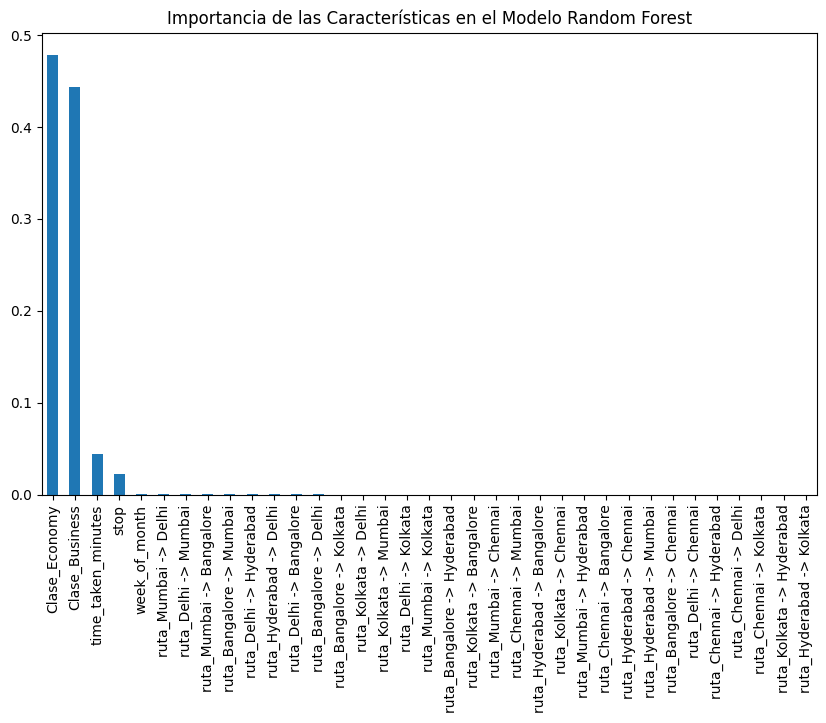

In [ ]:
# Revisar variables de importancia que arroja Ramdon Forest
feature_importances = pd.Series(optimal_forest_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_sorted.plot(kind='bar')
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.show()

In [ ]:
# Validación cruzada para el modelo de Random Forest
cv_scores = cross_val_score(optimal_forest_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = cv_scores.mean()

print("Promedio de MSE en validación cruzada: ", -mean_cv_score)

# Validación cruzada para el modelo de Árbol de Decisión
cv_scores_tree = cross_val_score(optimal_tree_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Dado que los scores están en negativo debido a que scikit-learn siempre trata de maximizar el rendimiento,
# la negación nos dará el MSE positivo que es más intuitivo
mean_cv_score_tree = cv_scores_tree.mean()

mean_cv_score_tree = -mean_cv_score_tree

print("Promedio de MSE en validación cruzada para el Árbol de Decisión: ", mean_cv_score_tree)


Promedio de MSE en validación cruzada:  0.0030740679917288724
Promedio de MSE en validación cruzada para el Árbol de Decisión:  0.002817015002069942


Un MSE de 0.00307 en este contexto indica que el modelo hace predicciones que, en promedio, se desvían del valor real en muy poco dentro del rango de la normalización del precio (1 y 0). Esto es indicativo de un modelo que está realizando muy bien dadas las escalas normalizadas de los precios.

Para el arbol de decisión el MSE es aun mas bajo, lo cual indica lo bien que estan prediciendo datos dichos modelos.